In [1]:
#import gpetas
import numpy as np
import pandas as pd
import datetime
time_format = "%Y-%m-%d %H:%M:%S.%f"

import matplotlib.pyplot as plt
import os

# auto reload using developer version
%load_ext autoreload
%autoreload 2

In [2]:
pwd

'/Volumes/data_SFB1294/Z010_now'

In [3]:
#fname = 'stundendaten/2021_B_S.txt'
fname = 'stundendaten/Axx/2021_A_S.txt'

In [4]:
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(fname,sep=';', low_memory=False)

data_3486 = df[df.Zst==3486]
data_1609 = df[df.Zst==1609]


In [5]:
print(len(df),np.sum(df.Zst==3486)*np.unique(df.Zst).shape[0])
print(np.sum(df.Zst==3486))
print(np.sum(df.Zst==1609))
print(np.unique(df.Wotag))
print(np.unique(df.Zst).shape)
print(24*365*898)

7866480 7866480
8760
8760
[1 2 3 4 5 6 7]
(898,)
7866480


In [23]:
# identify errors in the data
'''
idx_unique=np.unique(df.Zst)
for i in range(len(np.unique(df.Zst))):
    print(i,np.sum(df.Lkw_R1[df.Zst==idx_unique[i]]),np.sum(df.Lkw_R1[df.Zst==idx_unique[i]])+np.sum(df.Pkw_R1[df.Zst==idx_unique[i]])+np.sum(df.Lkw_R2[df.Zst==idx_unique[i]])+np.sum(df.Pkw_R2[df.Zst==idx_unique[i]]))
'''
idx_unique=np.unique(df.Zst)
dat_err = np.zeros([len(idx_unique),2])*np.nan
for i in range(len(np.unique(df.Zst))):
    dat_err[i,0] = int(idx_unique[i])
    dat_err[i,1] =np.sum(df.Lkw_R1[df.Zst==idx_unique[i]])

In [35]:
(np.sum(dat_err[:,1]<1),len(idx_unique))

(72, 898)

In [42]:
print('number of stations with erroneous data: %i (%.2f percent). Total number: %i.'%(np.sum(dat_err[:,1]<1),np.sum(dat_err[:,1]<1)/len(idx_unique),len(idx_unique)))

number of stations with erroneous data: 72 (0.08 percent). Total number: 898.


In [80]:
class extract_agg_data():
    """ Extracts aggregated data from hourly resoluted data
    """

    def __init__(self,data_all,aggregation=None):
        self.data_all=data_all
        df = data_all
        if aggregation=='day':
            bin_size = 24
            idx = df.Stunde==1
            self.bin_indices = np.where(idx==True)[0]
            self.days = np.arange(0,365,1)+df.Wotag[0]
            self.TKNR = df.TKNR[idx]
            self.Zst = df.Zst[idx]
            self.Land = df.Land[idx]
            self.Strklas = df.Strklas[idx]
            self.Strnum = df.Strnum[idx]
            self.Datum = df.Datum[idx]
            self.Wotag = df.Wotag[idx]
            self.Stunde = df.Stunde[idx]
            vector = np.array(df.Lkw_R1)
            self.Lkw_R1 = self.bin_sum(vector,bin_size)
            vector = np.array(df.Lkw_R2)
            self.Lkw_R2 = self.bin_sum(vector,bin_size)
        if aggregation=='week':
            bin_size = 24*7
            idx=((df.Stunde==1) & (df.Wotag==1))
            bin_indices = np.where(idx==True)[0]
            '''
            if bin_indices[0] > 0:
                bin_indices = np.hstack([0, bin_indices])
            if bin_indices[-1]+bin_size < len(df):
                bin_indices = np.hstack([bin_indices, len(df)-1])
            '''
            self.idx= idx
            self.bin_indices = bin_indices
            self.weeks = np.arange(0,52,1)+1
            idx = bin_indices
            self.TKNR = df.TKNR[idx]
            self.Zst = df.Zst[idx]
            self.Land = df.Land[idx]
            self.Strklas = df.Strklas[idx]
            self.Strnum = df.Strnum[idx]
            self.Datum = df.Datum[idx]
            self.Wotag = df.Wotag[idx]
            self.Stunde = df.Stunde[idx]
            vector = np.array(df.Lkw_R1)
            self.Lkw_R1 = self.bin_sum(vector,bin_size,bin_indices=bin_indices)
            vector = np.array(df.Lkw_R2)
            self.Lkw_R2 = self.bin_sum(vector,bin_size,bin_indices=bin_indices)
        if aggregation=='season':
            bin_size = None
            start_spring=[210320,11]
            start_summer=[210621,6]
            start_autumn=[210922,22]
            start_winter=[211221,17]
            s1=np.where((df.Datum==start_spring[0]) & (df.Stunde==start_spring[1]))[0]
            s2=np.where((df.Datum==start_summer[0]) & (df.Stunde==start_summer[1]))[0]
            s3=np.where((df.Datum==start_autumn[0]) & (df.Stunde==start_autumn[1]))[0]
            s4=np.where((df.Datum==start_winter[0]) & (df.Stunde==start_winter[1]))[0]
            bin_indices = np.sort(np.array([s1,s2,s3,s4]).reshape([1,-1]).squeeze())
            if bin_indices[0] > 0:
                bin_indices = np.hstack([0, bin_indices])
            self.bin_indices = bin_indices
            idx = bin_indices
            self.season = None
            self.TKNR = df.TKNR[idx]
            self.Zst = df.Zst[idx]
            self.Land = df.Land[idx]
            self.Strklas = df.Strklas[idx]
            self.Strnum = df.Strnum[idx]
            self.Datum = df.Datum[idx]
            self.Wotag = df.Wotag[idx]
            self.Stunde = df.Stunde[idx]
            vector = np.array(df.Lkw_R1)
            self.Lkw_R1 = self.bin_sum(vector,bin_size,bin_indices=bin_indices)
            vector = np.array(df.Lkw_R2)
            self.Lkw_R2 = self.bin_sum(vector,bin_size,bin_indices=bin_indices)
            
            
            
    def plot_daily(self,id=1609,color='k'):
        # plot definitions
        pSIZE = 20
        plt.rc('font', size=pSIZE)
        plt.rc('axes', titlesize=pSIZE)
        # figure()
        hf=plt.figure(figsize=(10,5))
        plt.plot(data_agg.days,data_agg.Lkw_R1[data_agg.Zst==id],color=color,linewidth=1)
        plt.show()
    
    def plot_weekly(self,id=1609,color='k'):
        # plot definitions
        pSIZE = 20
        plt.rc('font', size=pSIZE)
        plt.rc('axes', titlesize=pSIZE)
        # figure()
        hf=plt.figure(figsize=(10,5))
        plt.plot(data_agg.weeks,data_agg.Lkw_R1[data_agg.Zst==id],color=color,linewidth=1)
        plt.show()
    
    def bin_sum(self,vector,bin_size,bin_indices=None):
        if bin_indices is None:
            bin_indices = np.arange(0, len(vector), bin_size)
        bin_sums = np.add.reduceat(vector, bin_indices)
        self.control=bin_indices
        return bin_sums
            
            
                
        
            
            
            
            
        

In [84]:
data_agg = extract_agg_data(df,aggregation='week')

In [14]:
class data_weekly():
    pass

id_unique=np.unique(df.Zst)
data_weekly.KW=np.arange(1,54,1)

i=0
idx_i = id_unique[i]

idx_i = 1609
df_i = df[df.Zst==idx_i]
aux_idx=((df_i.Stunde==1) & (df_i.Wotag==1))
bin_indices = np.where(aux_idx==True)[0]
if bin_indices[0] > 0:
    bin_indices = np.hstack([0, bin_indices])

control_vec = np.ones(len(df_i))

In [40]:
idx_i = id_unique[i]
df_i = df[df.Zst==idx_i]
if np.sum(df_i.Pkw_R1)==0:
    print('Warning erroneous')

Warning


In [81]:
data_agg = extract_agg_data(df,aggregation='day')

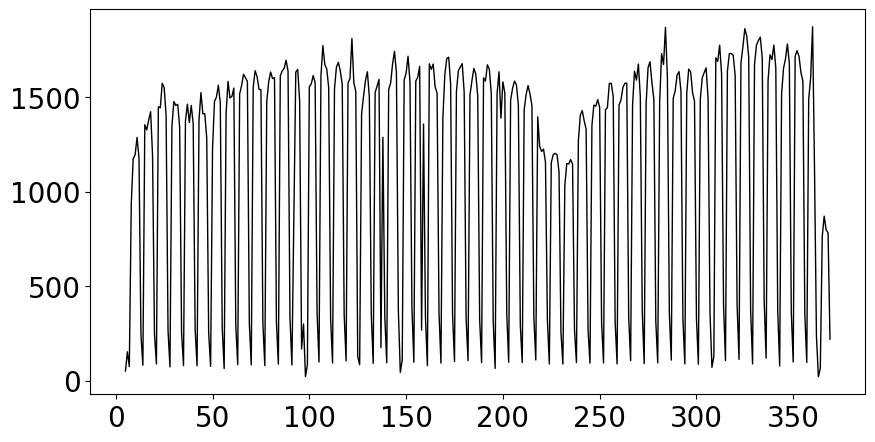

In [83]:
data_agg.plot_daily(123)

In [15]:
print(len(bin_indices))
bin_indices

53


array([   0,   72,  240,  408,  576,  744,  912, 1080, 1248, 1416, 1584,
       1752, 1920, 2088, 2256, 2424, 2592, 2760, 2928, 3096, 3264, 3432,
       3600, 3768, 3936, 4104, 4272, 4440, 4608, 4776, 4944, 5112, 5280,
       5448, 5616, 5784, 5952, 6120, 6288, 6456, 6624, 6792, 6960, 7128,
       7296, 7464, 7632, 7800, 7968, 8136, 8304, 8472, 8640])

In [46]:
vector=control_vec
bin_sums = np.add.reduceat(vector, bin_indices)
print(bin_sums)

NameError: name 'control_vec' is not defined

In [54]:
vector = np.array(df_i.Lkw_R1)
bin_sums = np.add.reduceat(vector, bin_indices)
print(bin_sums)

[6277 8007 7974 8287 7425 7685 7860 8251 7976 8284 8221 8700 7315 6691
 8685 8900 8878 8047 6708 8435 7470 8530 8662 8575 8686 8871 8785 8844
 9108 9127 8651 8699 8888 8694 8933 8971 9055 8778 8942 8650 8901 9027
 9125 8280 8534 8117 9290 7497 7592 8558 7306 3420]


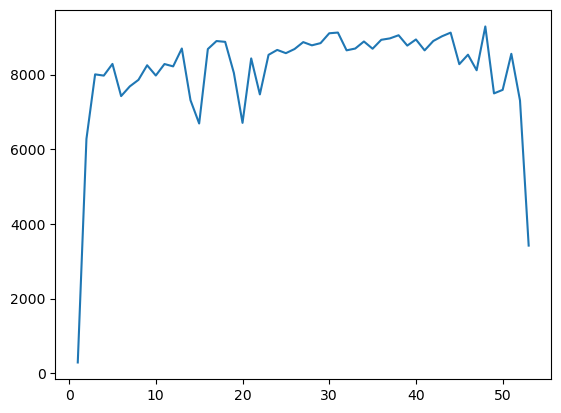

In [20]:
plt.plot(data_weekly.KW,bin_sums)

In [33]:
np.sum(data_agg.Lkw_R1[data_agg.Zst==1609])

429467

In [58]:
np.sum(df.Lkw_R1[df.Zst==1609])

429461

In [29]:
np.sum(bin_sums)

429461

In [263]:
class data_weekly():
    pass

id_unique,unique_indices=np.unique(df.Zst,return_index=True)
column_names = ['TKNR', 'Zst', 'Land', 'Strklas', 'KW', 'bin_sum']
formats = [int, int, int, 'S20', int, int]
data = np.array([], dtype={'names': column_names, 'formats': formats})
error_id=[]
error_A=[]
for i in range(len(id_unique)):
    idx_i = id_unique[i]
    df_i = df[df.Zst==idx_i]

    aux_idx=((df_i.Stunde==1) & (df_i.Wotag==1))
    bin_indices = np.where(aux_idx==True)[0]
    if bin_indices[0] > 0:
        bin_indices = np.hstack([0, bin_indices])
    if (np.sum(df.Lkw_R1[df.Zst==idx_i])+np.sum(df.Pkw_R1[df.Zst==idx_i]))<1:
        print('Warining BASt with ID %i at A%i has erroneous data.'%(idx_i,np.array(df_i.Strnum)[0]))
        error_id = np.append(error_id,idx_i)
        error_A = np.append(error_A,np.array(df_i.Strnum)[0])
    vector = np.array(df_i.Lkw_R1)
    bin_sums = np.add.reduceat(vector, bin_indices)
    kws = np.arange(1,54,1)
    Zst = np.ones(len(kws))*idx_i
    TKNR = np.ones(len(kws))*np.array(df_i.TKNR)[0]
    Land = np.ones(len(kws))*np.array(df_i.Land)[0]
    Strklas = [np.array(df_i.Strklas)[0]]*53
    values = bin_sums
    new_data = np.array(list(zip(TKNR, Zst, Land, Strklas, kws, values)), dtype={'names': column_names, 'formats': formats})
    data = np.append(data, new_data)

Warining BASt with ID 101 at A6 has erroneous data.
Warining BASt with ID 143 at A8 has erroneous data.
Warining BASt with ID 180 at A1 has erroneous data.
Warining BASt with ID 183 at A1 has erroneous data.
Warining BASt with ID 246 at A623 has erroneous data.
Warining BASt with ID 304 at A1 has erroneous data.
Warining BASt with ID 353 at A1 has erroneous data.
Warining BASt with ID 1604 at A19 has erroneous data.
Warining BASt with ID 1605 at A19 has erroneous data.
Warining BASt with ID 3836 at A2 has erroneous data.
Warining BASt with ID 4118 at A17 has erroneous data.
Warining BASt with ID 4344 at A71 has erroneous data.
Warining BASt with ID 4355 at A4 has erroneous data.
Warining BASt with ID 5066 at A44 has erroneous data.
Warining BASt with ID 5083 at A1 has erroneous data.
Warining BASt with ID 5127 at A33 has erroneous data.
Warining BASt with ID 5166 at A42 has erroneous data.
Warining BASt with ID 5602 at A57 has erroneous data.
Warining BASt with ID 5629 at A560 has erro

In [280]:
np.sort(error_A)
unique_values, counts = np.unique(error_A, return_counts=True)

In [285]:
unique_values

array([  1.,   2.,   3.,   4.,   6.,   7.,   8.,   9.,  17.,  19.,  33.,
        42.,  44.,  49.,  57.,  61.,  62.,  67.,  70.,  71.,  72.,  73.,
        92.,  93.,  94.,  99., 480., 560., 571., 623., 648., 650., 659.,
       661., 671.])

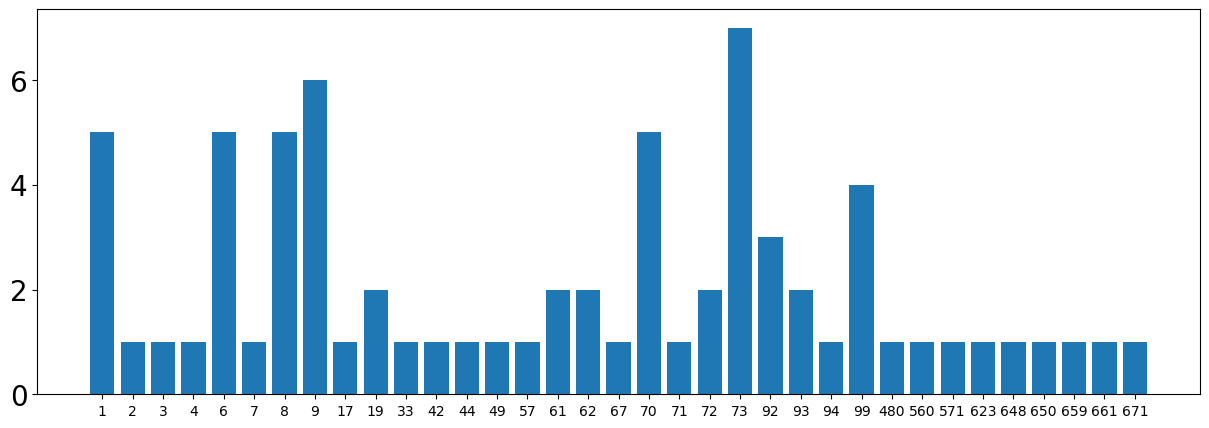

In [287]:
plt.figure(figsize=(15,5))
plt.bar(range(len(counts)),counts)
hf=plt.xticks(np.arange(0, len(counts) , 1), unique_values.astype(int),fontsize=10)

In [225]:
aux=data['bin_sum'].reshape([-1,53])

In [228]:
np.where(np.unique(data['Zst'])==3486)

(array([155]),)

In [247]:
np.max(aux,axis=0)
argmax = np.argmax(aux,axis=0)

In [249]:
np.unique(data['Zst'])[argmax]

array([8023, 5672, 3837, 3837, 3837, 3837, 8023, 5672, 5672, 8023, 5672,
       8023, 5672, 3837, 8023, 8023, 5672, 5672, 5672, 3489, 5672, 6808,
       3489, 8023, 5672, 5672, 6808, 5672, 6808, 5672, 5672, 5672, 5672,
       5672, 5672, 5672, 5672, 5672, 5672, 5672, 8023, 5672, 8023, 5672,
       3489, 5672, 5672, 8023, 8023, 5672, 5672, 3837, 5672])

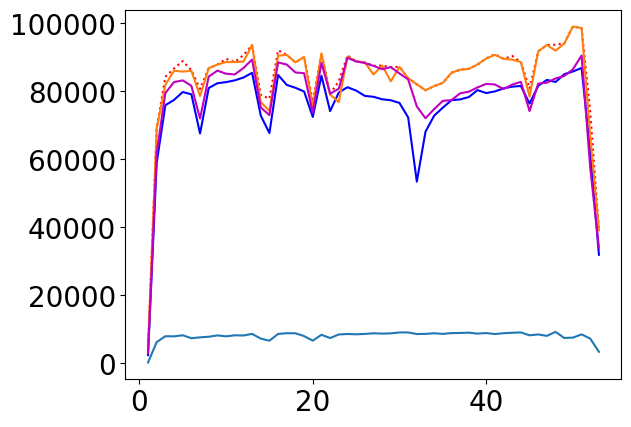

In [252]:
idx=data['Zst']==3486
plt.plot(data['KW'][idx],data['bin_sum'][idx],'b')
idx=data['Zst']==1609
plt.plot(data['KW'][idx],data['bin_sum'][idx])
plt.plot(data['KW'][idx],np.max(aux,axis=0),'r:')
idx=data['Zst']==5672
plt.plot(data['KW'][idx],data['bin_sum'][idx])
idx=data['Zst']==6808
plt.plot(data['KW'][idx],data['bin_sum'][idx],'m')

In [158]:
df_i

,TKNR,Zst,Land,Strklas,Strnum,Datum,Wotag,Fahrtzw,Stunde,KFZ_R1,...,Bus_R2,K_Bus_R2,LoA_R2,K_LoA_R2,Lzg_R2,K_Lzg_R2,Sat_R2,K_Sat_R2,Son_R2,K_Son_R2
6377280,6708,101,10,A,6,210101,5,s,1,153,...,0,a,0,a,0,a,0,a,0,a
6377281,6708,101,10,A,6,210101,5,s,2,109,...,0,a,0,a,0,a,0,a,0,a
6377282,6708,101,10,A,6,210101,5,s,3,67,...,0,a,0,a,0,a,0,a,0,a
6377283,6708,101,10,A,6,210101,5,s,4,55,...,0,a,0,a,0,a,0,a,0,a
6377284,6708,101,10,A,6,210101,5,s,5,51,...,0,a,0,a,0,a,0,a,0,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6386035,6708,101,10,A,6,211231,5,u,20,348,...,0,a,0,a,0,a,0,a,0,a
6386036,6708,101,10,A,6,211231,5,u,21,274,...,0,a,0,a,0,a,0,a,0,a
6386037,6708,101,10,A,6,211231,5,u,22,255,...,0,a,0,a,0,a,0,a,0,a
6386038,6708,101,10,A,6,211231,5,u,23,222,...,0,a,0,a,0,a,0,a,0,a


In [134]:
Strnum = 
Datum
Stunde
Lkw_R1
Lkw_R2

SyntaxError: invalid syntax (3420313787.py, line 1)

In [141]:
Strklas.T

AttributeError: 'list' object has no attribute 'T'

In [120]:
df_i

,TKNR,Zst,Land,Strklas,Strnum,Datum,Wotag,Fahrtzw,Stunde,KFZ_R1,...,Bus_R2,K_Bus_R2,LoA_R2,K_LoA_R2,Lzg_R2,K_Lzg_R2,Sat_R2,K_Sat_R2,Son_R2,K_Son_R2
0,7016,8001,8,A,5,210101,5,s,1,47,...,-1,x,-1,x,-1,x,-1,x,-1,x
1,7016,8001,8,A,5,210101,5,s,2,65,...,-1,x,-1,x,-1,x,-1,x,-1,x
2,7016,8001,8,A,5,210101,5,s,3,57,...,-1,x,-1,x,-1,x,-1,x,-1,x
3,7016,8001,8,A,5,210101,5,s,4,58,...,-1,x,-1,x,-1,x,-1,x,-1,x
4,7016,8001,8,A,5,210101,5,s,5,53,...,-1,x,-1,x,-1,x,-1,x,-1,x
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,7016,8001,8,A,5,211231,5,u,20,1079,...,-1,x,-1,x,-1,x,-1,x,-1,x
8756,7016,8001,8,A,5,211231,5,u,21,768,...,-1,x,-1,x,-1,x,-1,x,-1,x
8757,7016,8001,8,A,5,211231,5,u,22,353,...,-1,x,-1,x,-1,x,-1,x,-1,x
8758,7016,8001,8,A,5,211231,5,u,23,317,...,-1,x,-1,x,-1,x,-1,x,-1,x


In [103]:
bin_indices

array([   0,   72,  240,  408,  576,  744,  912, 1080, 1248, 1416, 1584,
       1752, 1920, 2088, 2256, 2424, 2592, 2760, 2928, 3096, 3264, 3432,
       3600, 3768, 3936, 4104, 4272, 4440, 4608, 4776, 4944, 5112, 5280,
       5448, 5616, 5784, 5952, 6120, 6288, 6456, 6624, 6792, 6960, 7128,
       7296, 7464, 7632, 7800, 7968, 8136, 8304, 8472, 8640])

In [113]:
df_i[1]

KeyError: 1

In [110]:
8760/24/7

52.142857142857146

In [66]:
sorted_values = id_unique[np.argsort(unique_indices)]

In [67]:
sorted_values

array([8001, 8002, 8003, 8004, 8005, 8009, 8010, 8012, 8013, 8020, 8021,
       8023, 8027, 8028, 8031, 8032, 8034, 8035, 8036, 8039, 8040, 8041,
       8043, 8045, 8049, 8050, 8053, 8054, 8055, 8061, 8068, 8073, 8075,
       8077, 8079, 8082, 8083, 8085, 8086, 8088, 8091, 8101, 8116, 8120,
       8128, 8129, 8140, 8158, 8168, 8175, 8180, 8181, 8184, 8746, 8998,
       9001, 9002, 9003, 9006, 9007, 9008, 9010, 9012, 9013, 9014, 9016,
       9017, 9018, 9019, 9020, 9021, 9023, 9024, 9025, 9026, 9027, 9028,
       9029, 9030, 9033, 9037, 9040, 9042, 9043, 9046, 9047, 9049, 9051,
       9054, 9058, 9059, 9061, 9062, 9063, 9064, 9065, 9066, 9067, 9068,
       9069, 9070, 9071, 9072, 9074, 9078, 9079, 9081, 9082, 9083, 9085,
       9087, 9088, 9090, 9093, 9094, 9095, 9096, 9097, 9099, 9101, 9106,
       9115, 9130, 9131, 9132, 9136, 9140, 9141, 9150, 9152, 9161, 9164,
       9165, 9166, 9167, 9171, 9180, 9184, 9190, 9191, 9192, 9203, 9207,
       9213, 9217, 9219, 9220, 9222, 9224, 9226, 92

In [59]:
np.sum(df.Lkw_R1[df.Zst==1609])

429461

In [82]:
bin_indices
if bin_indices[0] > 0:
    bin_indices = np.hstack([0, bin_indices])

In [84]:
print(len(bin_indices))
bin_indices

53


array([   0,   72,  240,  408,  576,  744,  912, 1080, 1248, 1416, 1584,
       1752, 1920, 2088, 2256, 2424, 2592, 2760, 2928, 3096, 3264, 3432,
       3600, 3768, 3936, 4104, 4272, 4440, 4608, 4776, 4944, 5112, 5280,
       5448, 5616, 5784, 5952, 6120, 6288, 6456, 6624, 6792, 6960, 7128,
       7296, 7464, 7632, 7800, 7968, 8136, 8304, 8472, 8640])

In [96]:
vector=control_vec
vector = np.array(df_i.Lkw_R1)
bin_sums = np.add.reduceat(vector, bin_indices)
print(bin_sums)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [94]:
print(len(control_vec))
print(len(df_i.Lkw_R1))

8760
8760


In [67]:
first_monday=np.where((df_i.Stunde==1) & (df_i.Wotag==1))[0][0]
last_monday=np.where((df_i.Stunde==1) & (df_i.Wotag==1))[0][-1]

In [105]:
np.sum(df.Lkw_R1[df.Zst==idx_i])

0

In [69]:
len(df_i)

8760

In [72]:
len(bin_indices)

52

In [57]:
bin_indices

0          False
1          False
2          False
3          False
4          False
           ...  
7866475    False
7866476    False
7866477    False
7866478    False
7866479    False
Length: 7866480, dtype: bool

In [29]:
data_agg.bin_indices

array([      0,      72,     240, ..., 7866024, 7866192, 7866360])

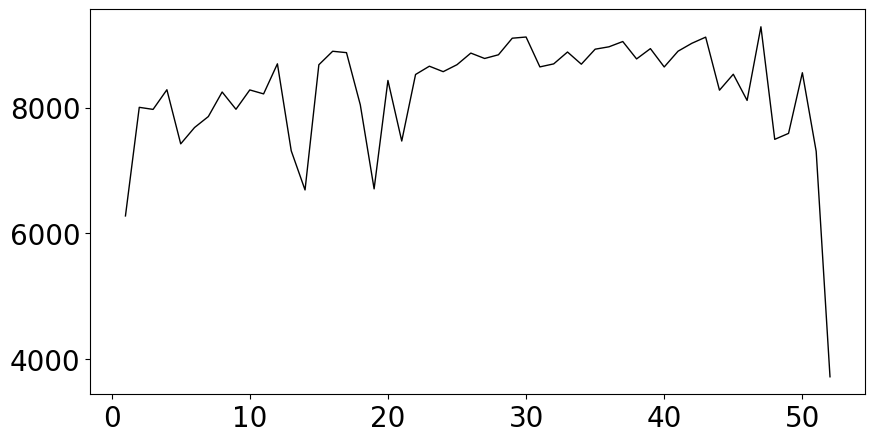

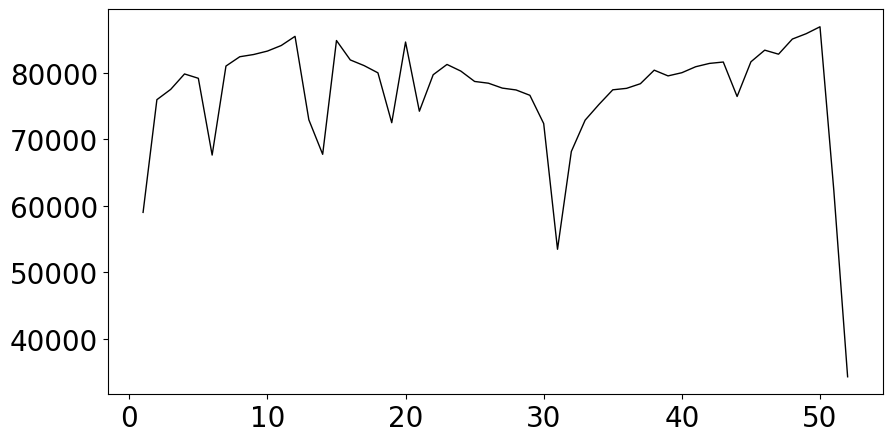

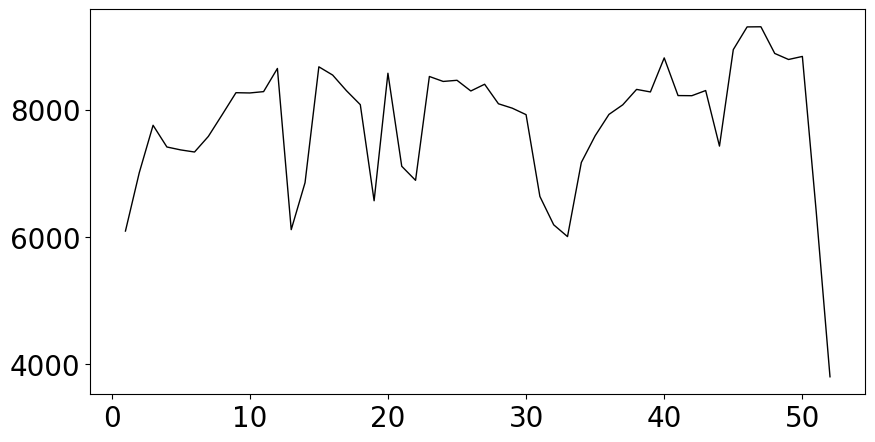

In [24]:
data_agg.plot_weekly(1609)
data_agg.plot_weekly(3486)
data_agg.plot_weekly(123)

In [7]:
np.arange(0,len(df)-1,365*np.unique(df.Zst).shape[0])

array([      0,  327770,  655540,  983310, 1311080, 1638850, 1966620,
       2294390, 2622160, 2949930, 3277700, 3605470, 3933240, 4261010,
       4588780, 4916550, 5244320, 5572090, 5899860, 6227630, 6555400,
       6883170, 7210940, 7538710])

In [8]:
idx_1 = np.where(df.Stunde==1)[0]
print(idx_1.shape)

(327770,)


In [11]:
hist, bin_edges = np.histogram(df.Lkw_R1, range=(0,len(df)),bins=np.unique(df.Zst).shape[0]*365)
ID_daily = df.Zst[idx_1]

In [21]:
bin_size=24
vector = np.array(df.Lkw_R1)
bin_sums = [np.sum(vector[i:i+bin_size]) for i in range(0, len(vector), bin_size)]


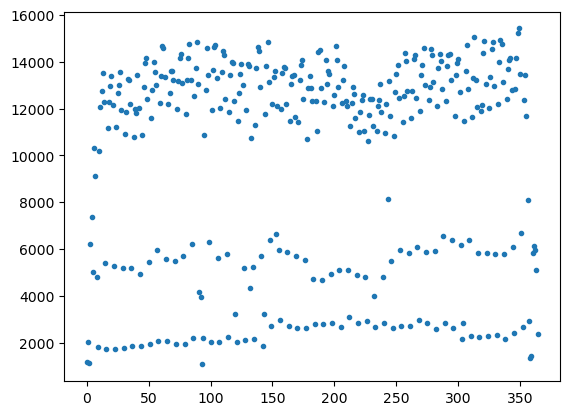

In [28]:
plt.plot(np.array(bin_sums)[ID_daily==8001],'.')

In [29]:
np.array(bin_sums)[ID_daily==8001][0]

1186

In [44]:
np.sum(df.Lkw_R1[df.Zst==8001][0:24])

1186

In [56]:
bin_indices-idx_1

array([0, 0, 0, ..., 0, 0, 0])

In [58]:
vector = np.array(df.Lkw_R1)
bin_size = 24
bin_indices = np.arange(0, len(vector), bin_size)
bin_sums = np.add.reduceat(vector, bin_indices)
ID_daily = df.Zst[bin_indices]
Wd_daily = df.Wotag[bin_indices]

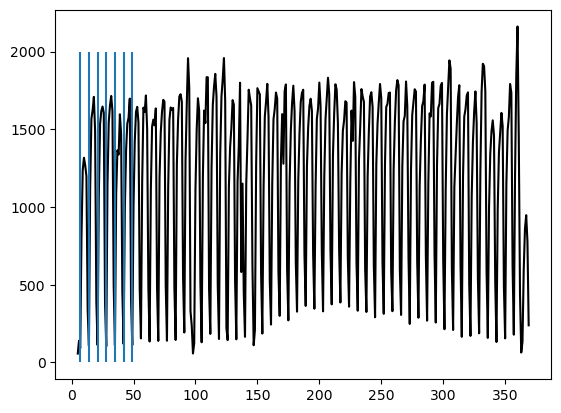

In [79]:
plt.figure()
plt.plot(np.arange(0,365,1)+Wd_daily[0],bin_sums[ID_daily==1609],'-k')
plt.vlines(np.arange(7,365/7,7),ymin=0,ymax=2000)

#plt.xlim([0,20])

In [65]:
Wd_daily[ID_daily==1609]

3740520    5
3740544    6
3740568    7
3740592    1
3740616    2
          ..
3749160    1
3749184    2
3749208    3
3749232    4
3749256    5
Name: Wotag, Length: 365, dtype: int64

In [42]:
bin_sums

array([1186, 2043, 1139, ...,  515,  421,  157])

In [529]:
class extract_agg_data():
    """ Extracts aggregated data from hourly resoluted data
    """

    def __init__(self,data_all,aggregation=None):
        self.data_all=data_all
        df = data_all
        if aggregation=='day':
            bin_size = 24
            idx = df.Stunde==1
            self.bin_indices = np.where(idx==True)[0]
            self.days = np.arange(0,365,1)+df.Wotag[0]
            self.TKNR = df.TKNR[idx]
            self.Zst = df.Zst[idx]
            self.Land = df.Land[idx]
            self.Strklas = df.Strklas[idx]
            self.Strnum = df.Strnum[idx]
            self.Datum = df.Datum[idx]
            self.Wotag = df.Wotag[idx]
            self.Stunde = df.Stunde[idx]
            vector = np.array(df.Lkw_R1)
            self.Lkw_R1 = self.bin_sum(vector,bin_size)
            vector = np.array(df.Lkw_R2)
            self.Lkw_R2 = self.bin_sum(vector,bin_size)
        if aggregation=='week':
            bin_size = 24*7
            idx=((df.Stunde==1) & (df.Wotag==1))
            bin_indices = np.where(idx==True)[0]
            if bin_indices[0] > 0:
                bin_indices = np.hstack([0, bin_indices])
            if bin_indices[-1]+bin_size < len(df):
                bin_indices = np.hstack([bin_indices, len(df)-1])
            self.idx= idx
            self.bin_indices = bin_indices
            self.weeks = np.arange(0,52,1)+1
            idx = bin_indices
            self.TKNR = df.TKNR[idx]
            self.Zst = df.Zst[idx]
            self.Land = df.Land[idx]
            self.Strklas = df.Strklas[idx]
            self.Strnum = df.Strnum[idx]
            self.Datum = df.Datum[idx]
            self.Wotag = df.Wotag[idx]
            self.Stunde = df.Stunde[idx]
            vector = np.array(df.Lkw_R1)
            self.Lkw_R1 = self.bin_sum(vector,bin_size,bin_indices=bin_indices)
            vector = np.array(df.Lkw_R2)
            self.Lkw_R2 = self.bin_sum(vector,bin_size,bin_indices=bin_indices)
        if aggregation=='season':
            bin_size = None
            start_spring=[210320,11]
            start_summer=[210621,6]
            start_autumn=[210922,22]
            start_winter=[211221,17]
            s1=np.where((df.Datum==start_spring[0]) & (df.Stunde==start_spring[1]))[0]
            s2=np.where((df.Datum==start_summer[0]) & (df.Stunde==start_summer[1]))[0]
            s3=np.where((df.Datum==start_autumn[0]) & (df.Stunde==start_autumn[1]))[0]
            s4=np.where((df.Datum==start_winter[0]) & (df.Stunde==start_winter[1]))[0]
            bin_indices = np.sort(np.array([s1,s2,s3,s4]).reshape([1,-1]).squeeze())
            if bin_indices[0] > 0:
                bin_indices = np.hstack([0, bin_indices])
            self.bin_indices = bin_indices
            idx = bin_indices
            self.season = None
            self.TKNR = df.TKNR[idx]
            self.Zst = df.Zst[idx]
            self.Land = df.Land[idx]
            self.Strklas = df.Strklas[idx]
            self.Strnum = df.Strnum[idx]
            self.Datum = df.Datum[idx]
            self.Wotag = df.Wotag[idx]
            self.Stunde = df.Stunde[idx]
            vector = np.array(df.Lkw_R1)
            self.Lkw_R1 = self.bin_sum(vector,bin_size,bin_indices=bin_indices)
            vector = np.array(df.Lkw_R2)
            self.Lkw_R2 = self.bin_sum(vector,bin_size,bin_indices=bin_indices)
            
            
            
    def plot_daily(self,id=1609,color='k'):
        # plot definitions
        pSIZE = 20
        plt.rc('font', size=pSIZE)
        plt.rc('axes', titlesize=pSIZE)
        # figure()
        hf=plt.figure(figsize=(10,5))
        plt.plot(data_agg.days,data_agg.Lkw_R1[data_agg.Zst==id],color=color,linewidth=1)
        plt.show()
    
    def bin_sum(self,vector,bin_size,bin_indices=None):
        if bin_indices is None:
            bin_indices = np.arange(0, len(vector), bin_size)
        bin_sums = np.add.reduceat(vector, bin_indices)
        self.control=bin_indices
        return bin_sums
            
            
                
        
            
            
            
            
        

In [554]:
data_agg = extract_agg_data(df,aggregation='weekly')

In [556]:
data_agg.plot_daily()

AttributeError: 'extract_agg_data' object has no attribute 'days'

<Figure size 1000x500 with 0 Axes>

In [531]:
id=8001
data_agg.Lkw_R1[data_agg.Zst==id].sum()

3947448

In [532]:
np.sum(df.Lkw_R1[df.Zst==id])

3631686

In [510]:
np.sum(df.Lkw_R1)

1303798910

In [475]:
24*7

168

In [423]:
data_agg = extract_agg_data(df,aggregation='season')

In [424]:
data_agg.bin_indices

array([   1882,    4109,    6357, ..., 7861829, 7864077, 7866232])

In [426]:
idx=((df.Stunde==1) & (df.Wotag==1))
bin_indices = np.where(idx==True)[0]

In [427]:
bin_indices

array([     72,     240,     408, ..., 7866024, 7866192, 7866360])

In [428]:
len(df)

7866480

In [430]:
np.hstack([0, bin_indices])

array([      0,      72,     240, ..., 7866024, 7866192, 7866360])

In [435]:
if bin_indices[0] > 0:
    bin_indices = np.hstack([0, bin_indices])
if bin_indices[-1] < len(df):
    bin_indices = np.hstack([bin_indices, len(df)])

In [436]:
bin_indices

array([      0,      72,     240, ..., 7866192, 7866360, 7866480])

<BarContainer object of 4 artists>

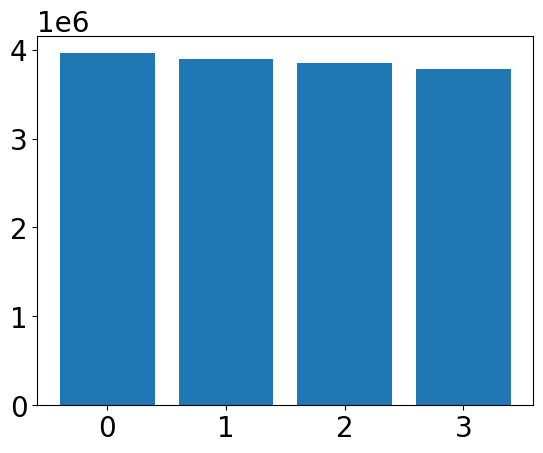

In [409]:
plt.bar(np.arange(0,4),data_agg.Lkw_R1[data_agg.Zst==3486])

In [352]:
data_agg.Lkw_R1[data_agg.Zst==3486].shape

(52,)

In [372]:
data_agg = extract_agg_data(df,aggregation='day')
print(np.sum(data_agg.Lkw_R1))
print(np.sum(df.Lkw_R1))

1303798910
1303798910


In [445]:
data_agg = extract_agg_data(df,aggregation='week')

In [ ]:
id=3486

1303798910
1303798910


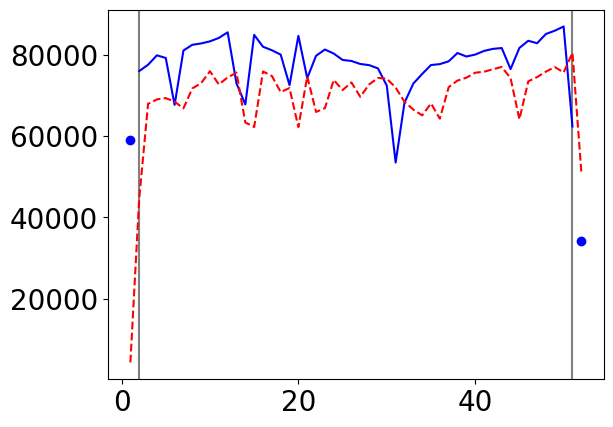

In [489]:
id=3486
#id=1609
plt.axvline(x=2,color='gray')
plt.axvline(x=51,color='gray')
plt.plot(data_agg.weeks[1:-1],data_agg.Lkw_R1[data_agg.Zst==id][1:-1],'b')
plt.plot(data_agg.weeks[0],data_agg.Lkw_R1[data_agg.Zst==id][0],'bo')
plt.plot(data_agg.weeks[-1],data_agg.Lkw_R1[data_agg.Zst==id][-1],'bo')
print(np.sum(data_agg.Lkw_R1))
print(np.sum(df.Lkw_R1))
plt.plot(data_agg.weeks,data_agg.Lkw_R1[data_agg.Zst==8001][:-1],'--r')

In [500]:
print(np.sum(data_agg.Zst==4384))
data_agg.Zst

52


0          8001
72         8001
240        8001
408        8001
576        8001
           ... 
7865688    4384
7865856    4384
7866024    4384
7866192    4384
7866360    4384
Name: Zst, Length: 46697, dtype: int64

In [480]:
np.diff(data_agg.bin_indices)
7866360-len(df)

-120

In [452]:
data_agg.bin_indices

array([      0,      72,     240, ..., 7866192, 7866360, 7866479])

In [365]:
boolean_vec=[False]*len(df)
boolean_vec[data_agg.bin_indices]=True


AttributeError: 'extract_agg_data' object has no attribute 'bin_indices'

In [344]:
len(df)/24/898/7

52.142857142857146

In [324]:



data_agg.bin_indices

array([   1882,   10642,   19402, ..., 7848712, 7857472, 7866232])

In [284]:
data_agg.Datum==start_spring

0          False
24         False
48         False
72         False
96         False
           ...  
7866360    False
7866384    False
7866408    False
7866432    False
7866456    False
Name: Datum, Length: 327770, dtype: bool

In [253]:
(df.Datum==211220)

21552

In [411]:
start_spring=[210320,11]
start_summer=[210621,6]
start_autumn=[210922,22]
start_winter=[211221,17]
idx1

0          False
1          False
2          False
3          False
4          False
           ...  
7866475    False
7866476    False
7866477    False
7866478    False
7866479    False
Length: 7866480, dtype: bool

In [533]:
idx1 = (df.Datum==start_spring[0]) & (df.Stunde==start_spring[1])
idx2 = (df.Datum==start_summer[0]) & (df.Stunde==start_summer[1])
idx3 = (df.Datum==start_autumn[0]) & (df.Stunde==start_autumn[1])
idx4 = (df.Datum==start_winter[0]) & (df.Stunde==start_winter[1])

In [534]:
s1=np.where((df.Datum==start_spring[0]) & (df.Stunde==start_spring[1]))[0]
s2=np.where((df.Datum==start_summer[0]) & (df.Stunde==start_summer[1]))[0]
s3=np.where((df.Datum==start_autumn[0]) & (df.Stunde==start_autumn[1]))[0]
s4=np.where((df.Datum==start_winter[0]) & (df.Stunde==start_winter[1]))[0]

In [542]:
tmp=df.Zst[s1[0]:s2[0]]

array([8001])

In [264]:
df[df.Datum==211220]

,TKNR,Zst,Land,Strklas,Strnum,Datum,Wotag,Fahrtzw,Stunde,KFZ_R1,...,Bus_R2,K_Bus_R2,LoA_R2,K_LoA_R2,Lzg_R2,K_Lzg_R2,Sat_R2,K_Sat_R2,Son_R2,K_Son_R2
8472,7016,8001,8,A,5,211220,1,w,1,377,...,-1,x,-1,x,-1,x,-1,x,-1,x
8473,7016,8001,8,A,5,211220,1,w,2,381,...,-1,x,-1,x,-1,x,-1,x,-1,x
8474,7016,8001,8,A,5,211220,1,w,3,349,...,-1,x,-1,x,-1,x,-1,x,-1,x
8475,7016,8001,8,A,5,211220,1,w,4,403,...,-1,x,-1,x,-1,x,-1,x,-1,x
8476,7016,8001,8,A,5,211220,1,w,5,735,...,-1,x,-1,x,-1,x,-1,x,-1,x
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7866211,5531,4384,16,A,73,211220,1,w,20,161,...,0,-,5,-,26,-,17,-,3,-
7866212,5531,4384,16,A,73,211220,1,w,21,119,...,0,-,0,-,23,-,15,-,1,-
7866213,5531,4384,16,A,73,211220,1,w,22,77,...,0,-,2,-,14,-,11,-,2,-
7866214,5531,4384,16,A,73,211220,1,w,23,68,...,0,-,1,-,16,-,9,-,0,-


In [257]:
df[df.Datum==211220].shape[0]/24

898.0

In [239]:
idx=((df.Stunde==1) & (df.Wotag==1))

np.where(idx==True)

(array([     72,     240,     408, ..., 7866024, 7866192, 7866360]),)

In [241]:
data_agg = extract_agg_data(df,aggregation='day')

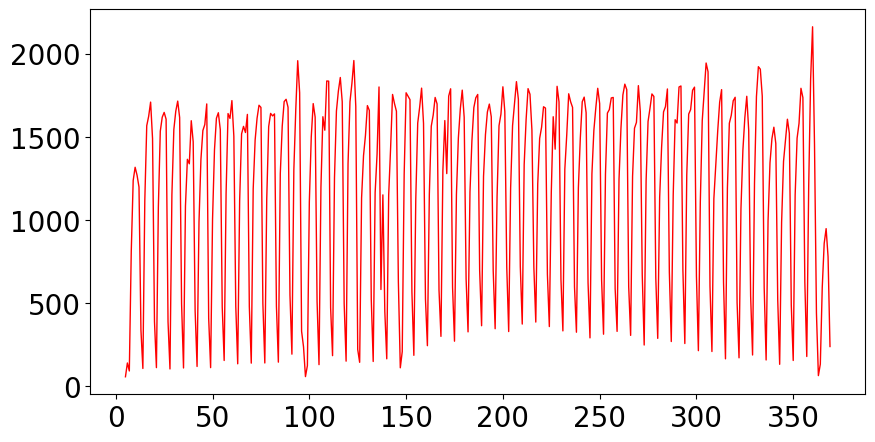

In [242]:
data_agg.plot_daily(1609,'r')

In [291]:
data_agg = extract_agg_data(df,aggregation='day')

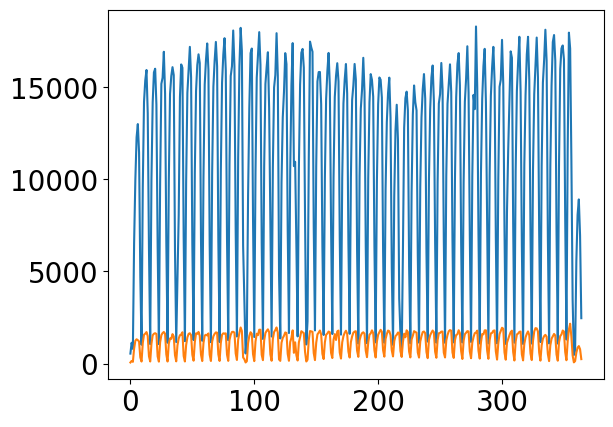

In [292]:
plt.plot(data_agg.Lkw_R1[data_agg.Zst==3486])
plt.plot(data_agg.Lkw_R1[data_agg.Zst==1609])

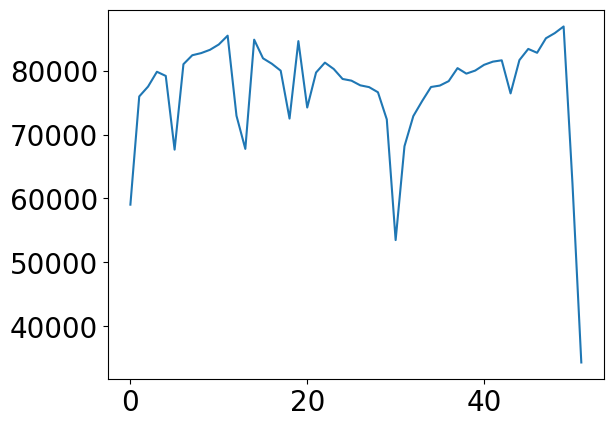

In [289]:
plt.plot(data_agg.Lkw_R1[data_agg.Zst==3486])

In [245]:
data_agg.Lkw_R1.shape

(46696,)

In [160]:
df

,TKNR,Zst,Land,Strklas,Strnum,Datum,Wotag,Fahrtzw,Stunde,KFZ_R1,...,Bus_R2,K_Bus_R2,LoA_R2,K_LoA_R2,Lzg_R2,K_Lzg_R2,Sat_R2,K_Sat_R2,Son_R2,K_Son_R2
0,7016,8001,8,A,5,210101,5,s,1,47,...,-1,x,-1,x,-1,x,-1,x,-1,x
1,7016,8001,8,A,5,210101,5,s,2,65,...,-1,x,-1,x,-1,x,-1,x,-1,x
2,7016,8001,8,A,5,210101,5,s,3,57,...,-1,x,-1,x,-1,x,-1,x,-1,x
3,7016,8001,8,A,5,210101,5,s,4,58,...,-1,x,-1,x,-1,x,-1,x,-1,x
4,7016,8001,8,A,5,210101,5,s,5,53,...,-1,x,-1,x,-1,x,-1,x,-1,x
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7866475,5531,4384,16,A,73,211231,5,u,20,53,...,0,-,0,-,2,-,1,-,1,-
7866476,5531,4384,16,A,73,211231,5,u,21,40,...,0,-,0,-,0,-,0,-,0,-
7866477,5531,4384,16,A,73,211231,5,u,22,31,...,0,-,0,-,2,-,2,-,0,-
7866478,5531,4384,16,A,73,211231,5,u,23,18,...,0,-,1,-,0,-,0,-,0,-


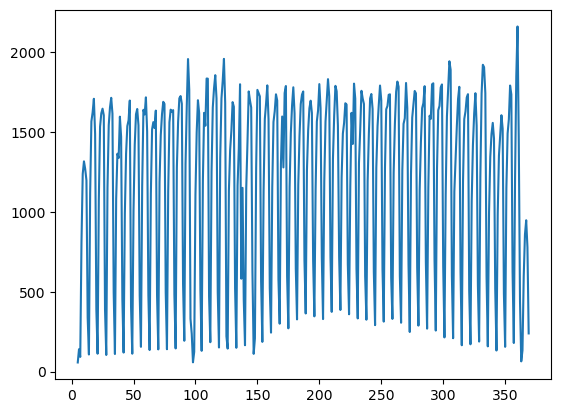

In [115]:
id=1609
plt.figure()
plt.plot(data_agg.days,data_agg.Lkw_R1[data_agg.Zst==id])

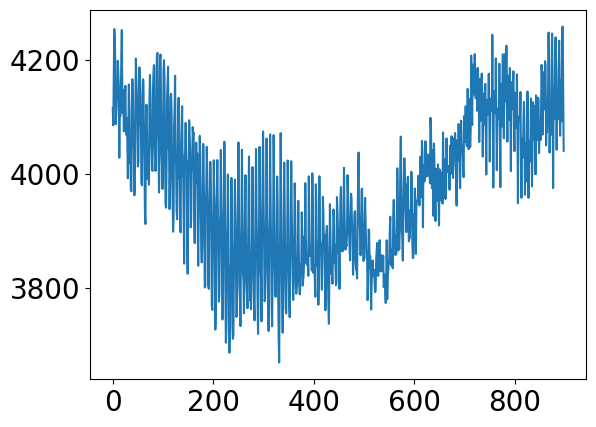

In [200]:
plt.plot(np.mean(data_agg.Lkw_R1.reshape([365,-1]),axis=0))

ValueError: x and y must have same first dimension, but have shapes (365,) and (898,)

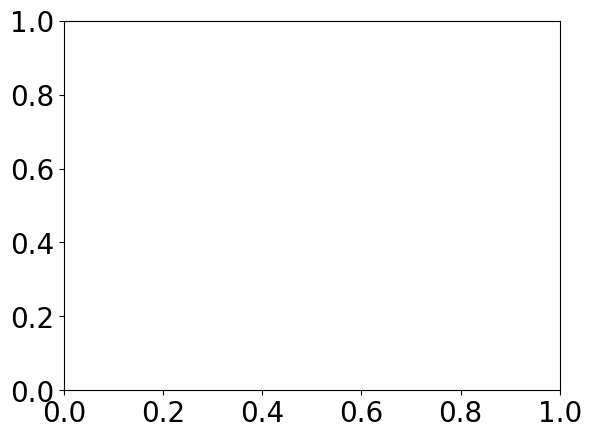

In [193]:
plt.plot(data_agg.days,np.mean(data_agg.Lkw_R1.reshape([365,-1]),axis=0))

In [134]:
data_agg = extract_agg_data(df,aggregation='day')

In [136]:
data_agg.df.Lkw_R1

0           21
24          61
48          31
72          88
96         113
          ... 
7866360      6
7866384      8
7866408      3
7866432     10
7866456      9
Name: Lkw_R1, Length: 327770, dtype: int64

In [102]:
data_obj.data_daily.Wotag

0          5
24         6
48         7
72         1
96         2
          ..
7866360    1
7866384    2
7866408    3
7866432    4
7866456    5
Name: Wotag, Length: 327770, dtype: int64

In [13]:
data_obj.d

,TKNR,Zst,Land,Strklas,Strnum,Datum,Wotag,Fahrtzw,Stunde,KFZ_R1,...,Bus_R2,K_Bus_R2,LoA_R2,K_LoA_R2,Lzg_R2,K_Lzg_R2,Sat_R2,K_Sat_R2,Son_R2,K_Son_R2
0,7016,8001,8,A,5,210101,5,s,1,47,...,-1,x,-1,x,-1,x,-1,x,-1,x
1,7016,8001,8,A,5,210101,5,s,2,65,...,-1,x,-1,x,-1,x,-1,x,-1,x
2,7016,8001,8,A,5,210101,5,s,3,57,...,-1,x,-1,x,-1,x,-1,x,-1,x
3,7016,8001,8,A,5,210101,5,s,4,58,...,-1,x,-1,x,-1,x,-1,x,-1,x
4,7016,8001,8,A,5,210101,5,s,5,53,...,-1,x,-1,x,-1,x,-1,x,-1,x
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7866475,5531,4384,16,A,73,211231,5,u,20,53,...,0,-,0,-,2,-,1,-,1,-
7866476,5531,4384,16,A,73,211231,5,u,21,40,...,0,-,0,-,0,-,0,-,0,-
7866477,5531,4384,16,A,73,211231,5,u,22,31,...,0,-,0,-,2,-,2,-,0,-
7866478,5531,4384,16,A,73,211231,5,u,23,18,...,0,-,1,-,0,-,0,-,0,-


In [8]:
print(len(df),np.sum(df.Zst==3486)*np.unique(df.Zst).shape[0])
print(np.sum(df.Zst==3486))
print(np.sum(df.Zst==1609))
print(np.unique(df.Wotag))


7866480 7866480
8760
8760
[1 2 3 4 5 6 7]


In [130]:
# weekday np.array(df.Lkw_R1[(df.Zst==1609) & (df.Wotag==1)])
dat_agg = {'weekday_amount_R1': []}
dat_agg_1609 = {'weekday_amount_R1': []}
dat_agg_3486 = {'weekday_amount_R1': []}
for i in np.arange(1,8,1):
    dat_agg['weekday_amount_R1'].append(np.array(df.Lkw_R1[df.Wotag==i]))
    dat_agg_1609['weekday_amount_R1'].append(np.array(df.Lkw_R1[(df.Zst==1609) & (df.Wotag==i)]))
    dat_agg_3486['weekday_amount_R1'].append(np.array(df.Lkw_R1[(df.Zst==3486) & (df.Wotag==i)]))


KeyboardInterrupt



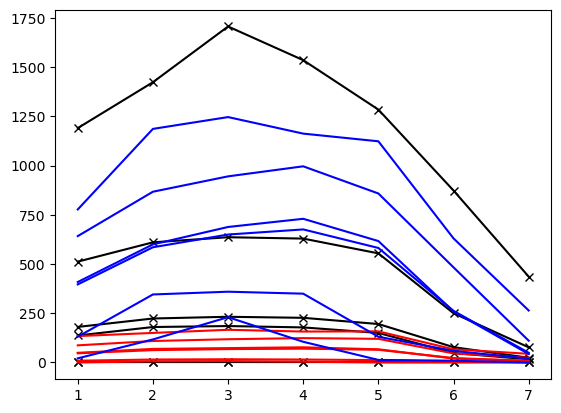

In [136]:
quantile=0.05
plt.figure()
dat = np.zeros([7,6])
dat_1609 = np.zeros([7,6])
dat_3486 = np.zeros([7,6])
for i in range(7):
    dat[i,:6]=[np.mean(dat_agg['weekday_amount_R1'][i]),
                np.median(dat_agg['weekday_amount_R1'][i]),
                np.quantile(dat_agg['weekday_amount_R1'][i],q=quantile),
                np.quantile(dat_agg['weekday_amount_R1'][i],q=1-quantile),
                np.min(dat_agg['weekday_amount_R1'][i]),
                np.max(dat_agg['weekday_amount_R1'][i])]
    dat_1609[i,:6]=[np.mean(dat_agg_1609['weekday_amount_R1'][i]),
                np.median(dat_agg_1609['weekday_amount_R1'][i]),
                np.quantile(dat_agg_1609['weekday_amount_R1'][i],q=quantile),
                np.quantile(dat_agg_1609['weekday_amount_R1'][i],q=1-quantile),
                np.min(dat_agg_1609['weekday_amount_R1'][i]),
                np.max(dat_agg_1609['weekday_amount_R1'][i])]
    dat_3486[i,:6]=[np.mean(dat_agg_3486['weekday_amount_R1'][i]),
                np.median(dat_agg_3486['weekday_amount_R1'][i]),
                np.quantile(dat_agg_3486['weekday_amount_R1'][i],q=quantile),
                np.quantile(dat_agg_3486['weekday_amount_R1'][i],q=1-quantile),
                np.min(dat_agg_3486['weekday_amount_R1'][i]),
                np.max(dat_agg_3486['weekday_amount_R1'][i])]
                           
    #dat[i,1]=
#plt.step(np.arange(1,8,1),dat,'k-',where='mid')
plt.plot(np.arange(1,8,1),dat,'-kx')
plt.plot(np.arange(1,8,1),dat_1609,'r')
plt.plot(np.arange(1,8,1),dat_3486,'b')

In [25]:
df

(8760,)

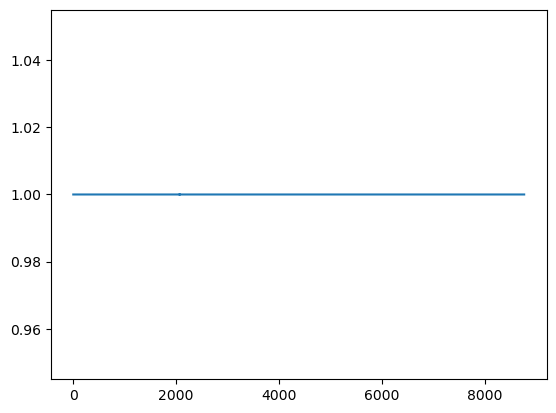

In [29]:
#plt.plot(np.array(data_3486.Lkw_R1))
plt.plot(df_3486_A2.Lkw_R1/np.array(data_3486.Lkw_R1))
#plt.plot(data_1609.Lkw_R1)

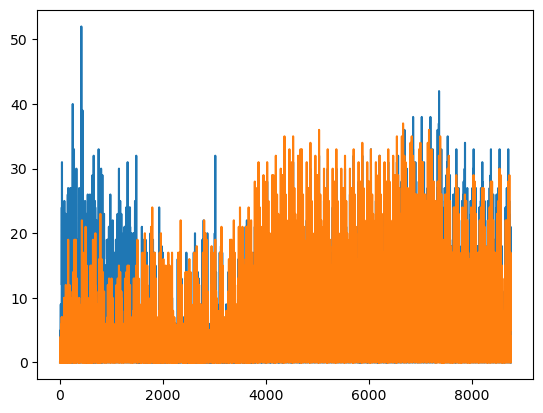

In [41]:
plt.plot(data.Lfw_R1)
plt.plot(data.Lfw_R2)

In [44]:
data = df[df.Zst==3486]

In [45]:
data

,TKNR,Zst,Land,Strklas,Strnum,Datum,Wotag,Fahrtzw,Stunde,KFZ_R1,...,Bus_R2,K_Bus_R2,LoA_R2,K_LoA_R2,Lzg_R2,K_Lzg_R2,Sat_R2,K_Sat_R2,Son_R2,K_Son_R2


In [27]:
# 3486
fname_3486 = 'stundendaten/zst3486_2021.csv'
fname_1609 = 'stundendaten/zst1609_2021.csv'
# Read the CSV file into a Pandas DataFrame
df_3486_A2 = pd.read_csv(fname_3486,sep=';')
df_1609_A20 = pd.read_csv(fname_1609,sep=';')

In [59]:
print(df_3486.head())

   TKNR   Zst  Land Strklas  Strnum   Datum  Wotag Fahrtzw  Stunde  KFZ_R1  \
0  3627  3486     3       A       2  210101      5       s       1     105   
1  3627  3486     3       A       2  210101      5       s       2     155   
2  3627  3486     3       A       2  210101      5       s       3     152   
3  3627  3486     3       A       2  210101      5       s       4     112   
4  3627  3486     3       A       2  210101      5       s       5      74   

   ... Bus_R2  K_Bus_R2 LoA_R2  K_LoA_R2 Lzg_R2  K_Lzg_R2 Sat_R2  K_Sat_R2  \
0  ...      0         -      3         -      9         -      8         -   
1  ...      0         -      0         -      9         -      9         -   
2  ...      0         -      0         -      7         -      6         -   
3  ...      0         -      3         -      2         -      2         -   
4  ...      0         -      0         -      7         -      7         -   

  Son_R2  K_Son_R2  
0      0         -  
1      0         -  

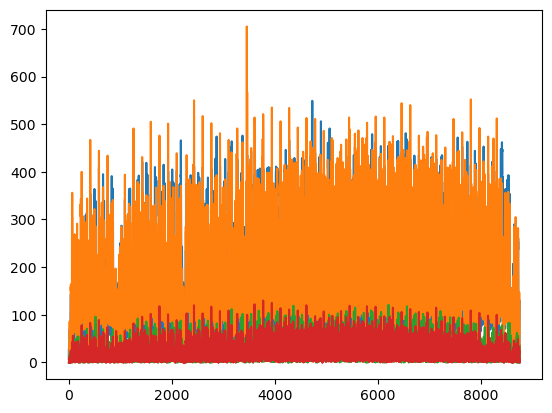

In [63]:
#plt.plot(df_3486.Lfw_R1)
plt.plot(df_3486_A2.Lfw_R1)
plt.plot(df_3486_A2.Lfw_R2)
plt.plot(df_1609_A20.Lfw_R1)
plt.plot(df_1609_A20.Lfw_R2)


In [50]:
vars(df_3486)

{'_is_copy': None,
 '_mgr': BlockManager
 Items: Index(['TKNR', 'Zst', 'Land', 'Strklas', 'Strnum', 'Datum', 'Wotag', 'Fahrtzw',
        'Stunde', 'KFZ_R1', 'K_KFZ_R1', 'KFZ_R2', 'K_KFZ_R2', 'Lkw_R1',
        'K_Lkw_R1', 'Lkw_R2', 'K_Lkw_R2', 'PLZ_R1', 'K_PLZ_R1', 'Pkw_R1',
        'K_Pkw_R1', 'Lfw_R1', 'K_Lfw_R1', 'Mot_R1', 'K_Mot_R1', 'PmA_R1',
        'K_PmA_R1', 'Bus_R1', 'K_Bus_R1', 'LoA_R1', 'K_LoA_R1', 'Lzg_R1',
        'K_Lzg_R1', 'Sat_R1', 'K_Sat_R1', 'Son_R1', 'K_Son_R1', 'PLZ_R2',
        'K_PLZ_R2', 'Pkw_R2', 'K_Pkw_R2', 'Lfw_R2', 'K_Lfw_R2', 'Mot_R2',
        'K_Mot_R2', 'PmA_R2', 'K_PmA_R2', 'Bus_R2', 'K_Bus_R2', 'LoA_R2',
        'K_LoA_R2', 'Lzg_R2', 'K_Lzg_R2', 'Sat_R2', 'K_Sat_R2', 'Son_R2',
        'K_Son_R2'],
       dtype='object')
 Axis 1: RangeIndex(start=0, stop=8760, step=1)
 NumericBlock: [ 0  1  2  4  5  6  8  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41
  43 45 47 49 51 53 55], 31 x 8760, dtype: int64
 ObjectBlock: [ 3  7 10 12 14 16 18 20 22 24 26 28 3

In [55]:
np.unique(df_3486.Datum)

array([210101, 210102, 210103, 210104, 210105, 210106, 210107, 210108,
       210109, 210110, 210111, 210112, 210113, 210114, 210115, 210116,
       210117, 210118, 210119, 210120, 210121, 210122, 210123, 210124,
       210125, 210126, 210127, 210128, 210129, 210130, 210131, 210201,
       210202, 210203, 210204, 210205, 210206, 210207, 210208, 210209,
       210210, 210211, 210212, 210213, 210214, 210215, 210216, 210217,
       210218, 210219, 210220, 210221, 210222, 210223, 210224, 210225,
       210226, 210227, 210228, 210301, 210302, 210303, 210304, 210305,
       210306, 210307, 210308, 210309, 210310, 210311, 210312, 210313,
       210314, 210315, 210316, 210317, 210318, 210319, 210320, 210321,
       210322, 210323, 210324, 210325, 210326, 210327, 210328, 210329,
       210330, 210331, 210401, 210402, 210403, 210404, 210405, 210406,
       210407, 210408, 210409, 210410, 210411, 210412, 210413, 210414,
       210415, 210416, 210417, 210418, 210419, 210420, 210421, 210422,
      

In [66]:
df.Lfw_R1

0        7
1       29
2       10
3        6
4        4
        ..
8755    37
8756    22
8757    18
8758    11
8759    12
Name: Lfw_R1, Length: 8760, dtype: int64

In [15]:
len(df)

6850320

In [ ]:
df.

In [8]:
import pandas as pd

# Load the large CSV file into a DataFrame in chunks
chunk_size = 10000  # Adjust this based on your available memory
csv_file_path = fname

# Use a loop to process chunks of data
for chunk in pd.read_csv(csv_file_path, chunksize=chunk_size):
    # Process the chunk (e.g., perform calculations or filtering)
    # For example: chunk['column_name'].mean()

# Alternatively, you can read the entire file into a DataFrame:
# df = pd.read_csv(csv_file_path)

SyntaxError: incomplete input (2432105773.py, line 13)